### For Details and Installation of TOMOBAR Package please refer to: https://github.com/dkazanc/ToMoBAR
### Tested on:
- python=3.6.11
- Tomobar=2020.10
- astra-toolbox=1.9.9
- ccpi-regulariser=20.04
- numpy=1.14.6
- pytorch=1.4.0

In [2]:
import astra
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N_size = 320
angles_num = 23 # angles number
angles = np.linspace(0.0,180,180,dtype='float32',endpoint=False)
angles = angles[::8]
angles_rad = angles*(np.pi/180.0)
P = int(np.sqrt(2)*N_size) #detectors

# Predict Single

In [5]:
import cv2
sinogram = cv2.imread('../../Toy-Dataset/Ground_Truth_sinogram/C/47.png',0)
sinogram = cv2.resize(sinogram, (180,320))
print(sinogram.shape)
sinogram = sinogram[:,::8].T
print(sinogram.shape)

(320, 180)
(23, 320)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%Reconstructing with FBP method %%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Text(0.5, 1.0, 'FBP reconstruction')

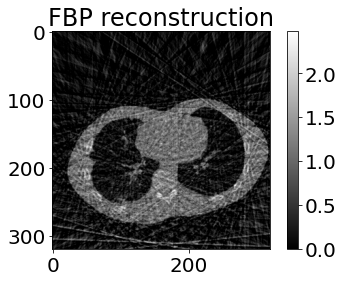

In [6]:
print ("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print ("%%%%%%%%%%%%%%Reconstructing with FBP method %%%%%%%%%%%%%%%")
print ("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = N_size,         # Horizontal detector dimension
                    DetectorsDimV = None,            # Vertical detector dimension (3D case)
                    CenterRotOffset  = 0.001,         # Center of Rotation scalar
                    AnglesVec = angles_rad,          # A vector of projection angles in radians
                    ObjSize = N_size,                # Reconstructed object dimensions (scalar)
                    device_projector='gpu')

FBPrec = RectoolsDIR.FBP(sinogram) # perform FBP reconstruction
FBPrec = np.clip(FBPrec, a_min=0, a_max=None)
plt.figure()
plt.rcParams.update({'font.size': 20})
plt.imshow(FBPrec, cmap="gray") #vmin=0, vmax=1, 
plt.colorbar(orientation='vertical')
plt.title('FBP reconstruction')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Reconstructing with FISTA method (ASTRA used for projection)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Parameters check has been succesfull, running the algorithm...
FISTA iteration ( 1 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 62 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 123 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 184 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 245 ) using PD_TV regularisation for ( 150 ) iterations
FISTA stopped at iteration ( 300 )


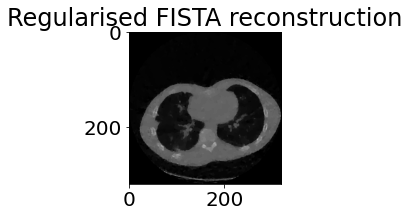

In [7]:
print ("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print ("Reconstructing with FISTA method (ASTRA used for projection)")
print ("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
from tomobar.methodsIR import RecToolsIR

# set parameters and initiate a class object
Rectools = RecToolsIR(DetectorsDimH = N_size,             # Horizontal detector dimension
                    DetectorsDimV = None,            # Vertical detector dimension (3D case)
                    CenterRotOffset = None,          # Center of Rotation scalar
                    AnglesVec = angles_rad,          # A vector of projection angles in radians
                    ObjSize = N_size,                # Reconstructed object dimensions (scalar)
                    datafidelity='LS',               # Data fidelity, choose from LS, KL, PWLS
                    device_projector='gpu')

# prepare dictionaries with parameters:
_data_ = {'projection_norm_data' : sinogram} # data dictionary
lc = Rectools.powermethod(_data_) # calculate Lipschitz constant (run once to initialise)
_algorithm_ = {'iterations' : 300,
               'lipschitz_const' : lc}

# adding regularisation using the CCPi regularisation toolkit
_regularisation_ = {'method' : 'PD_TV',
                    'regul_param' : 0.0001,
                    'iterations' : 150,
                    'device_regulariser': 'gpu'}

RecFISTA_reg = Rectools.FISTA(_data_, _algorithm_, _regularisation_)

plt.subplot(122)
plt.imshow(RecFISTA_reg, cmap="gray")# vmin=0, vmax=1,
# plt.colorbar(orientation='vertical')#ticks=[0, 0.5, 1], 
plt.title('Regularised FISTA reconstruction')
plt.show()

# Predict All

In [8]:
import torch
import torchvision.utils as vutils
from tomobar.methodsIR import RecToolsIR
from glob import glob
import cv2
import os

In [9]:
Rectools = RecToolsIR(DetectorsDimH = N_size,        # Horizontal detector dimension
                    DetectorsDimV = None,            # Vertical detector dimension (3D case)
                    CenterRotOffset = None,          # Center of Rotation scalar
                    AnglesVec = angles_rad,          # A vector of projection angles in radians
                    ObjSize = N_size,                # Reconstructed object dimensions (scalar)
                    datafidelity='LS',               # Data fidelity, choose from LS, KL, PWLS
                    device_projector='gpu')

_algorithm_ = {'iterations' : 300,
               'lipschitz_const' : lc}

In [12]:
datadir = '../../Toy-Dataset/Ground_Truth_sinogram/N/'  # CHANGE ME for different directory: C/L/N
writedir = '../../Toy-Dataset/Fista/N/'  # CHANGE ME for different directory: C/L/N

try:
    if not os.path.exists(writedir):
        os.makedirs(writedir)
        print(f'Created {writedir} directory')
except OSError:
    pass

for fn in os.listdir(datadir):
    print(fn)
    sinogram = cv2.imread(datadir+fn, 0)
    sinogram = cv2.resize(sinogram, (180,320))
    sinogram = sinogram[:,::8].T
    
    _data_ = {'projection_norm_data' : sinogram} # data dictionary
    lc = Rectools.powermethod(_data_) # calculate Lipschitz constant (run once to initialise)
    RecFISTA_reg = Rectools.FISTA(_data_, _algorithm_, _regularisation_)
    
    vutils.save_image(torch.FloatTensor(RecFISTA_reg), f'{writedir}{fn}', normalize=True)    

16.png
Parameters check has been succesfull, running the algorithm...
FISTA iteration ( 1 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 62 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 123 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 184 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 245 ) using PD_TV regularisation for ( 150 ) iterations
FISTA stopped at iteration ( 300 )
12.png
Parameters check has been succesfull, running the algorithm...
FISTA iteration ( 1 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 62 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 123 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 184 ) using PD_TV regularisation for ( 150 ) iterations
FISTA iteration ( 245 ) using PD_TV regularisation for ( 150 ) iterations
FISTA stopped at iteration ( 300 )
19.png
Parameters check has been succesfull, running the